In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from collections import Counter
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## TODO: usar string.punctuation para limpiar signos de puntuación

In [2]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
%matplotlib inline

In [4]:
datos_originales = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="DATOS ORIGINALES")

In [5]:
stopwords = set(["con","como","no","de","y","en","el","a","que","para","la",
                 "mas","un","una","los","puede","o","las","es","al","se","más",
                 "si","del","por"])

In [6]:
def clean_and_pre_process(corpus):
    
    corpus = corpus.lower()
    corpus = corpus.translate(str.maketrans('', '', string.punctuation))
    
    return corpus

clean_and_pre_process("hola mundo. este , es un. tipo;")

'hola mundo este  es un tipo'

In [7]:
preguntas_abiertas = datos_originales[datos_originales.columns[4:]]

corpus_global = ""

for column in preguntas_abiertas.columns:
    corpus_global = corpus_global + preguntas_abiertas[column].str.cat(sep=" ")
    
corpus_global = clean_and_pre_process(corpus_global)

word_to_int = dict()
int_to_word = dict()
for idx,word in enumerate(corpus_global.split()):
    word_to_int[word] = idx
    int_to_word[idx] = word

In [8]:
def calc_tf_idf(documents_series):
    vectorizer = CountVectorizer(min_df=.00025, max_df=.1)
    counts = vectorizer.fit_transform(documents_series)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(counts.toarray()).toarray()
    
    return counts,transformer,vectorizer,tfidf

result,transformer,vectorizer,tfidf = calc_tf_idf(datos_originales[datos_originales.columns[4]])

print(vectorizer)

check = 3
for i in range(result.shape[1]):
    if result[check,i] > 0:
        print(result[check,i],vectorizer.get_feature_names()[i],tfidf[check,i])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=None, min_df=0.00025,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
1 algun 0.19668710704762613
1 algún 0.19668710704762613
1 así 0.17795813779799904
1 basado 0.19668710704762613
1 cantidad 0.19668710704762613
1 características 0.19668710704762613
1 descubrimiento 0.19668710704762613
1 entre 0.19668710704762613
1 gran 0.17795813779799904
1 histórico 0.19668710704762613
2 identificar 0.3559162755959981
1 imagenes 0.19668710704762613
1 imágenes 0.16466972264001448
1 las 0.1459407533903874
1 maquina 0.19668710704762613
1 médico 0.16466972264001448
1 paciente 0.1543624270743957
1 patrón 0.19668710704762613
1 permita 0.19668710704762613
1 permite 0.19668710704762613
1 poder 0.1459407

In [9]:
def analisis_frecuencia_palabras(corpus):
    figure = plt.figure(figsize =(15,15))
    
    corpus = clean_and_pre_process(corpus)
    corpus_list = corpus.split()
    vocabulario = set(corpus_list)
    conteo_corpus = Counter(corpus_list)
    conteo_corpus   = Counter({key: conteo_corpus[key] for key in conteo_corpus if key not in stopwords})
    bigramas = list(nltk.bigrams(corpus_list))
    conteo_bigramas = Counter(bigramas)
    conteo_bigramas = Counter({bigram:conteo_bigramas[bigram] for bigram in conteo_bigramas if bigram[0] not in stopwords and bigram[1] not in stopwords})
    trigramas = list(nltk.trigrams(corpus_list))
    conteo_trigramas = Counter(trigramas)
    conteo_trigramas = Counter({trigram:conteo_trigramas[trigram] for trigram in conteo_trigramas if trigram[0] not in stopwords and trigram[1] not in stopwords})
    
    
    palabra,conteo  = zip(*conteo_corpus.most_common())
    
    figure.add_subplot(2,3,1).barh(palabra[:10],conteo[:10])
    
    wordcloud_corpus = WordCloud(stopwords=stopwords).generate(corpus)
    figure.add_subplot(2,3,4).imshow(wordcloud_corpus,interpolation="bilinear",aspect="auto")
    #plt.show()
    
    bigramas_comunes,conteo = zip(*conteo_bigramas.most_common())
    bigrama = [" ".join(bigram) for bigram in bigramas_comunes]
    figure.add_subplot(2,3,2).barh(bigrama[:10],conteo[:10])
    #plt.show()
    
    wordcloud_bigrams = WordCloud().generate(" ".join(["_".join(bigram)  for bigram in bigramas_comunes[:15]]))
    figure.add_subplot(2,3,5).imshow(wordcloud_bigrams,interpolation="bilinear",aspect="auto")
    
    
    trigramas_comunes,conteo = zip(*conteo_trigramas.most_common())
    trigrama = [" ".join(trigram) for trigram in trigramas_comunes]
    figure.add_subplot(2,3,3).barh(trigrama[:10],conteo[:10])
    
    wordcloud_trigramas = WordCloud().generate(" ".join(["_".join(trigram) for trigram in trigramas_comunes[:15]]))
    figure.add_subplot(2,3,6).imshow(wordcloud_trigramas,interpolation ="bilinear",aspect="auto")
    
    plt.show()
    return corpus_list,vocabulario



### Análisis de frecuencia global

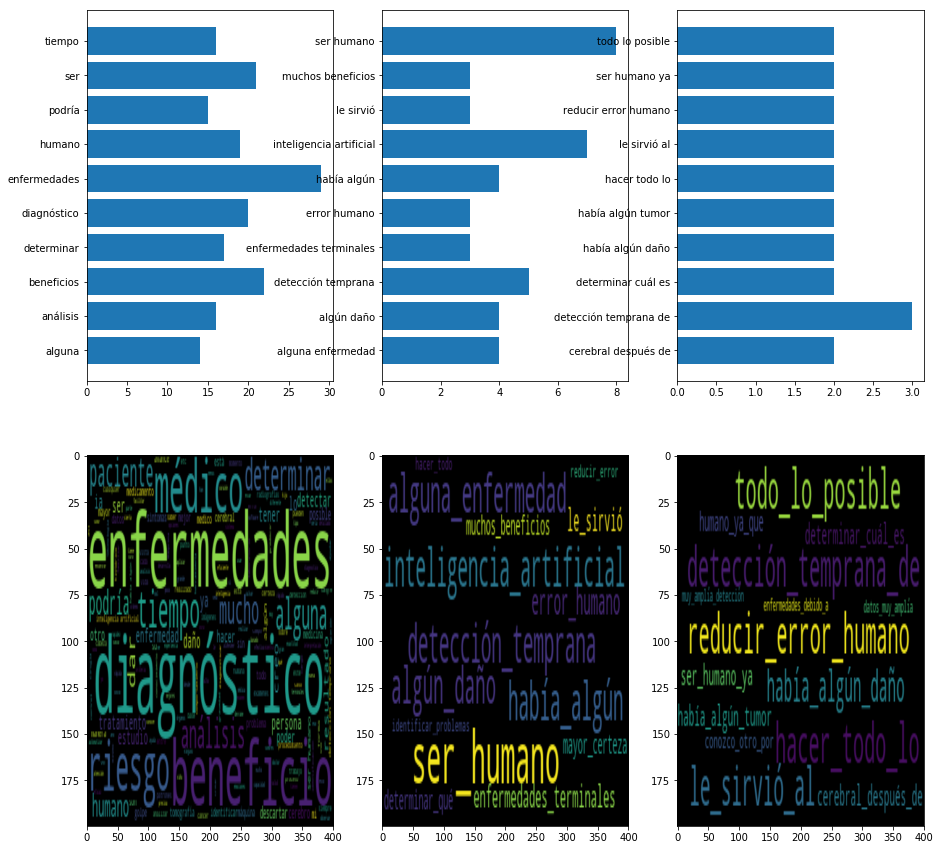

In [10]:
resultado =  analisis_frecuencia_palabras(corpus_global)


Podemos observar algunas cosas interesantes
* "diagnóstico" es predominante, lo cual indica que se cree que la IA puede ser usada para diagnóstico.
* "beneficio" es también predominante, la percepción hacía la IA es mayormente positiva, aun que podemos ver que también esta presente la palabra "riesgo" , se necesita analizar no por palabras si no por n-gramas para ver que palabras acompañan a riesgo, con el objetivo de determinar si en conjunto con otras palabras la muestra expresa que considera que existirá una disminución de riesgo o bien si consieran a la IA riesgosa.
* "enfermedades" es otra palabra predominante ,algo posiblemente de esperarse y posiblemente asociado con "diagnóstico"

## Pregunta 1:  ¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?

### Análisis de frecuencia de palabras

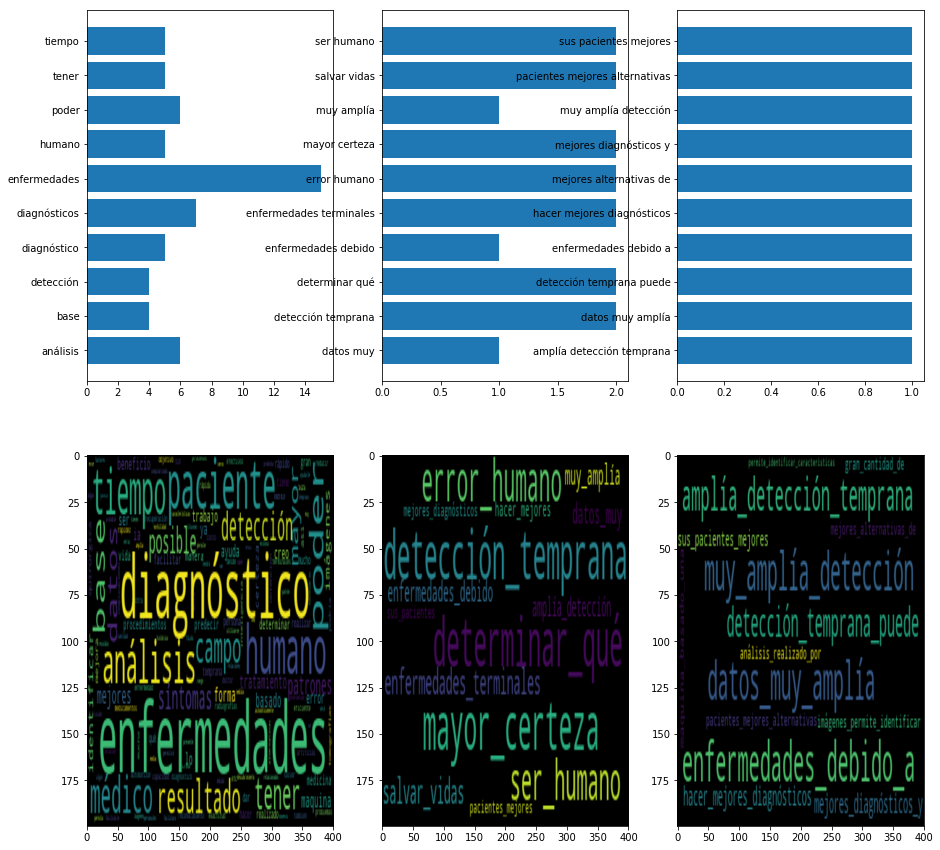

In [11]:
resultados_pregunta1 = datos_originales["¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"]
pregunta1_corpus = resultados_pregunta1.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta1_corpus)

## Pregunta 2:  Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?

### Análisis de frecuencia de palabras

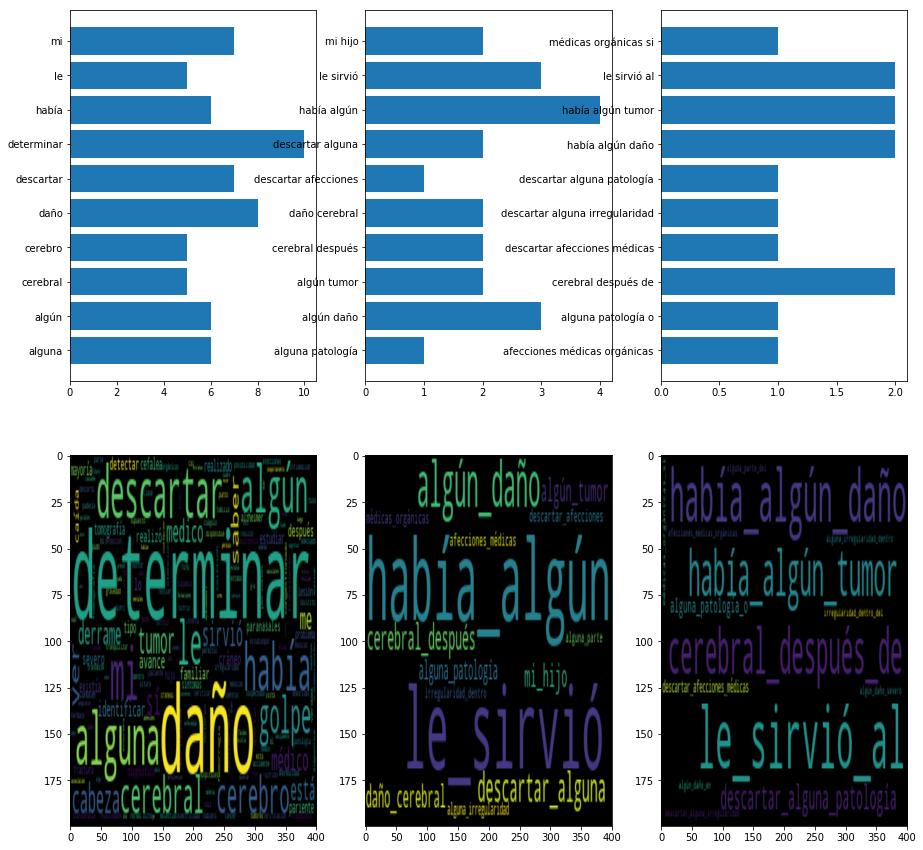

In [12]:
resultados_pregunta2 = datos_originales["Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?"]
pregunta2_corpus = resultados_pregunta2.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta2_corpus)

## Pregunta 3: ¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?

### Análisis de frecuencia de palabras

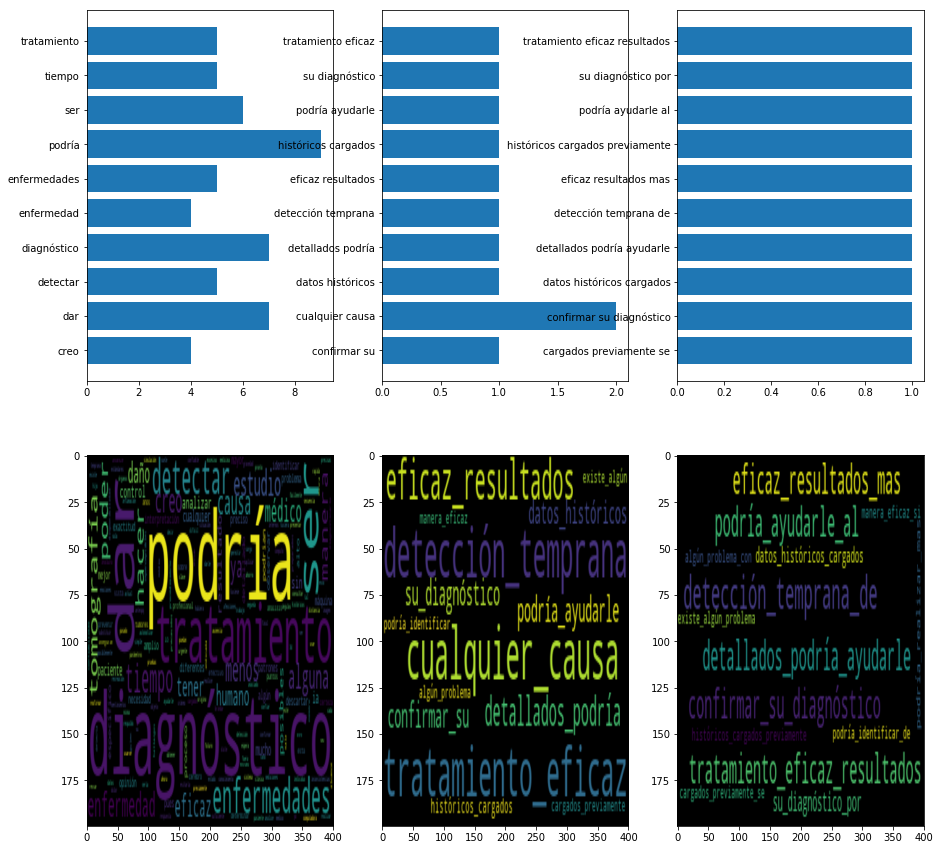

In [13]:
resultados_pregunta3 = datos_originales["¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?"]
pregunta3_corpus = resultados_pregunta3.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta3_corpus)

## Pregunta 4: En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?

### Análisis de frecuencia de palabras

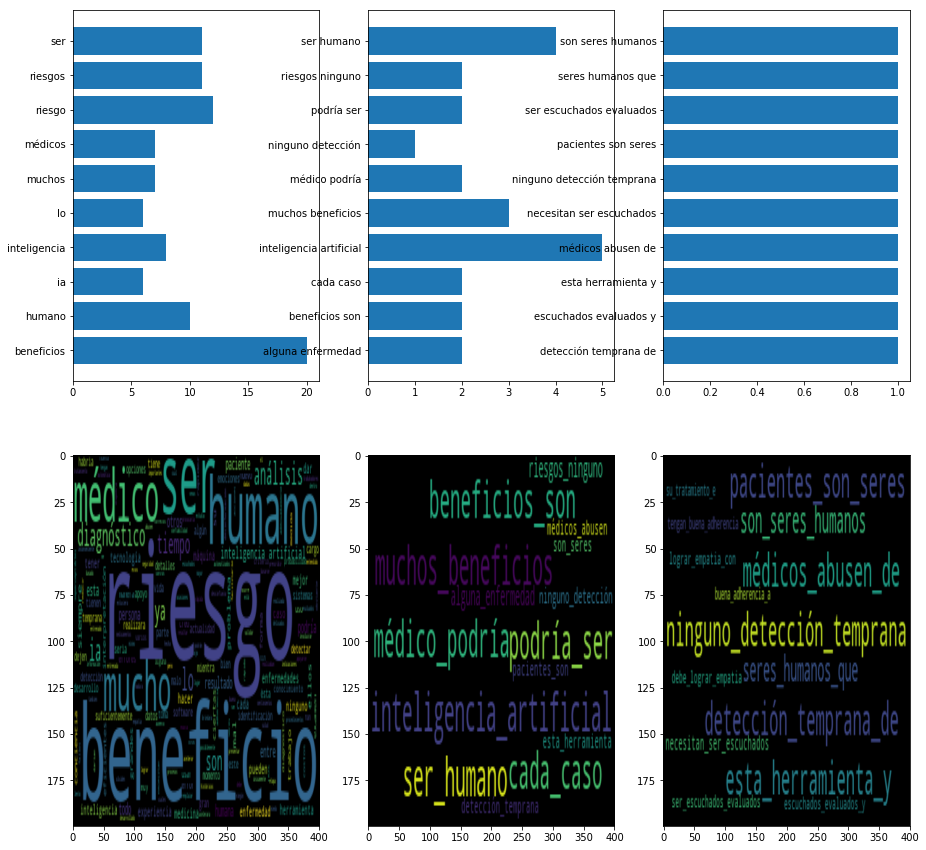

In [14]:
resultados_pregunta3 = datos_originales["En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?"]
pregunta3_corpus = resultados_pregunta3.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta3_corpus)

## Pregunta 5: ¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?


### Análisis de frecuencia de palabras

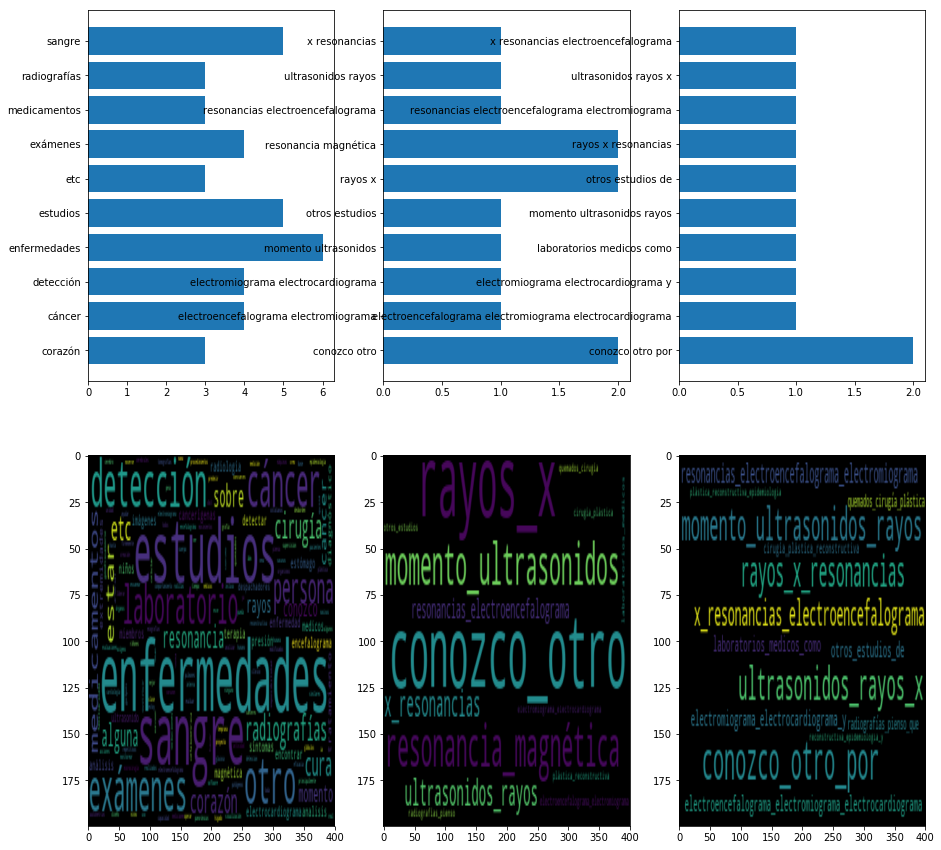

In [15]:
resultados_pregunta4 = datos_originales["¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?"]
pregunta4_corpus = resultados_pregunta4.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta4_corpus)